In [54]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize


import warnings
warnings.filterwarnings("ignore")

In [55]:
params = { 
    'for_stats' : 'data/LE_Lisket_0_15_AMBI_DEF_stat.csv',
    'for_ml' : 'data/LE_Lisket_0_15_AMBI_DEF_ml.csv',
    'str_cols' : ['Group', 'Gender', 'Season'],
    'not_for_ml' : ['Group', 'Gender', 'Season', 'NR', 'Year', 'Paradigm', 'id', 'Generation'],
    'not_corr_cols' : ['Group', 'Gender', 'Season', 'NR', 'Year', 'Paradigm', 'id', 'Generation', 'Group'],
    'generation_cut' : 13,
    'generation_under_cut' : 6,
    'seed' : 42
}

In [56]:
#Helper functions

def plot_violin_gen(data, col, gen = 1):
    """Shows the distribution of the specified column and generation by gender

    Args:
        data (pd.DataFrame): Data to plot from
        col (str): Column to plot distribution
        gen (int, optional): Generation to filter by. Defaults to 1.
    """
    if data[col].dtype == 'object':
        raise ValueError(f"Column '{col}' must be numeric to plot grouped means.")

    df_cpy = data.loc[data['Generation'] == gen, [col, 'Gender']].copy()
    sns.violinplot(df_cpy, y=col, hue='Gender')
    plt.title(f'Distribution of {col} for Generation {gen}', fontsize=16)
    plt.show()


def plot_grouped(data, col, divide_by_group = True):
    """Plots grouped mean valuesa as bar plots through generations

    Args:
        data (pd.DataFrame): Data to plot from
        col (str): Column to plot grouped bar plots for
        divide_by_group (bool): Defaults to True. Determines to plot by gender or by Group.
    """

    if data[col].dtype == 'object':
        raise ValueError(f"Column '{col}' must be numeric to plot grouped means.")

    divider = 'Group' if divide_by_group else 'Gender'
    df_cpy = data[['Generation', divider, col]].copy()
    df_cpy = df_cpy.groupby(['Generation', divider])[col].mean().reset_index()
    sns.barplot(df_cpy, x='Generation', y=col, hue=divider)
    plt.title(f'Average {col} by Generation and {divider}', fontsize=16)
    plt.show()



## Statistics

In [57]:
#Readading the data
data = pd.read_csv(params['for_ml'])
data

,Generation,Season,Paradigm,Year,NR,Group,Gender,EAT_E_%,EAT_I_%,EAT_TOT_%%,...,A_E_4,Expl_E_BEF_Loco_ratio_4,Expl_I_BEF_Loco_ratio_4,Expl_EI_BEF_Loco_ratio_4,Expl_E_TOT_Loco_ratio_4,Expl_I_TOT_Loco_ratio_4,Expl_E_I_TOT_Loco_ratio_4,Eff_Expl_I_4,Eff_Expl_EI_4,Eff_Expl_All_4
0,0,Autumn,1.0,0.0,1,Lisket,Male,100.0,75.0,87.50,...,27.586207,1.666667,3.166667,4.833333,1.857143,2.357143,4.214286,1.0,0.500000,1.0
1,0,Autumn,1.0,0.0,2,Lisket,Male,87.5,75.0,81.25,...,33.333333,2.666667,5.333333,8.000000,1.529412,2.117647,3.647059,1.0,0.571429,1.0
2,0,Autumn,1.0,0.0,3,Lisket,Male,100.0,75.0,87.50,...,40.000000,3.000000,7.000000,10.000000,2.076923,3.076923,5.153846,1.0,0.571429,1.0
3,0,Autumn,1.0,0.0,4,LE,Male,87.5,87.5,87.50,...,30.769231,4.500000,8.500000,13.000000,2.818182,3.727273,6.545455,1.0,0.571429,1.0
4,0,Autumn,1.0,0.0,5,Lisket,Male,50.0,75.0,62.50,...,33.333333,2.666667,5.333333,8.000000,1.888889,3.222222,5.111111,1.0,0.533333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,15,Winter,1.0,6.0,95,LE,Male,87.5,50.0,68.75,...,25.806452,2.000000,3.166667,5.166667,1.105263,1.578947,2.684211,1.0,0.500000,1.0
1338,15,Winter,1.0,6.0,96,LE,Male,100.0,75.0,87.50,...,34.782609,1.166667,2.666667,3.833333,1.260870,1.565217,2.826087,1.0,0.571429,1.0
1339,15,Winter,1.0,6.0,97,LE,Male,100.0,75.0,87.50,...,44.444444,0.500000,1.750000,2.250000,1.350000,1.450000,2.800000,1.0,0.666667,1.0
1340,15,Winter,1.0,6.0,98,LE,Male,100.0,100.0,100.00,...,32.000000,0.900000,1.600000,2.500000,0.968750,1.343750,2.312500,1.0,0.533333,1.0


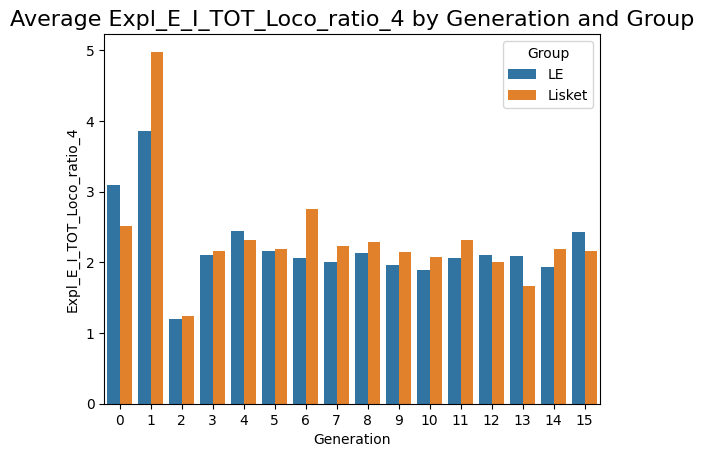

In [58]:
#Plotting the mean value through the generations and by gendersŰ
plot_grouped(data, 'Expl_E_I_TOT_Loco_ratio_4')


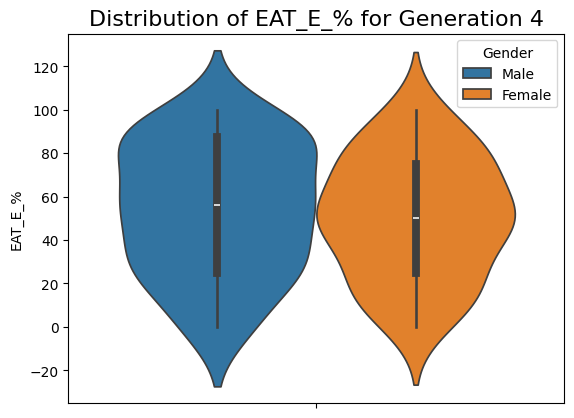

In [59]:
plot_violin_gen(data, 'EAT_E_%', 4)

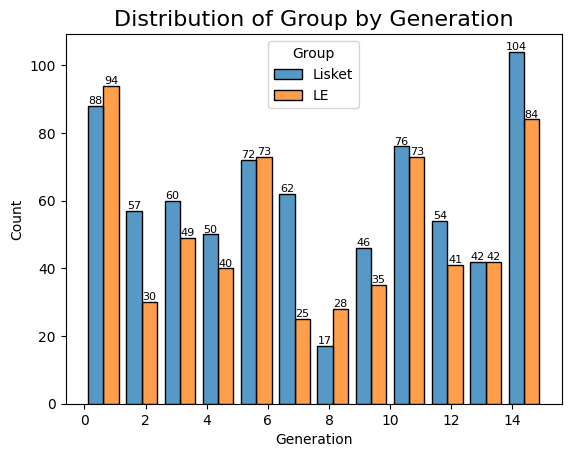

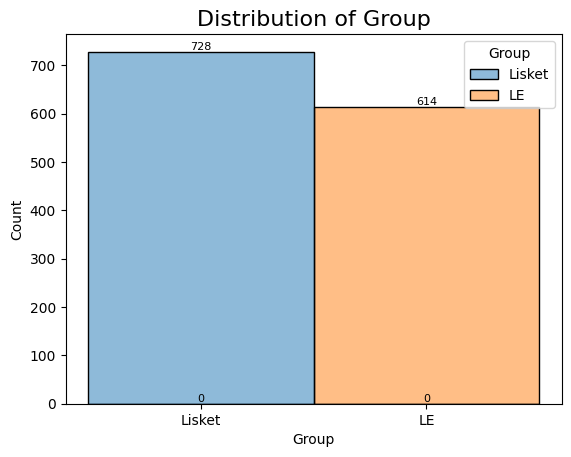

In [60]:
#As our goal is to predict whether a rat belongs to Lisket or LE we plot the distribution of Group by Generation and in general
ax = sns.histplot(data, x='Generation', multiple='dodge', hue='Group', shrink= 0.8)
ax.bar_label(ax.containers[0], label_type='edge', fontsize=8)
ax.bar_label(ax.containers[1], label_type='edge', fontsize=8)
plt.title('Distribution of Group by Generation', fontsize=16)
plt.show()

#Group label distribution over all generations
ax = sns.histplot(data, x='Group', hue='Group')
ax.bar_label(ax.containers[0], label_type='edge', fontsize=8)
ax.bar_label(ax.containers[1], label_type='edge', fontsize=8)
plt.title('Distribution of Group', fontsize=16)
plt.show()


## Machine learning

In [61]:
#Normalizeing the data with each generation separately
data_normalized = data.copy()
for gen in data['Generation'].unique():
    gen_data = data[data['Generation'] == gen]
    numeric_cols = [col for col in gen_data.columns if col not in params['not_for_ml'] and gen_data[col].dtype in ['float64', 'int64']]
    data_normalized.loc[data['Generation'] == gen, numeric_cols] = normalize(gen_data[numeric_cols])
data_normalized


,Generation,Season,Paradigm,Year,NR,Group,Gender,EAT_E_%,EAT_I_%,EAT_TOT_%%,...,A_E_4,Expl_E_BEF_Loco_ratio_4,Expl_I_BEF_Loco_ratio_4,Expl_EI_BEF_Loco_ratio_4,Expl_E_TOT_Loco_ratio_4,Expl_I_TOT_Loco_ratio_4,Expl_E_I_TOT_Loco_ratio_4,Eff_Expl_I_4,Eff_Expl_EI_4,Eff_Expl_All_4
0,0,Autumn,1.0,0.0,1,Lisket,Male,0.001262,0.000947,0.001104,...,0.000348,0.000021,0.000040,0.000061,0.000023,0.000030,0.000053,0.000013,0.000006,0.000013
1,0,Autumn,1.0,0.0,2,Lisket,Male,0.000892,0.000764,0.000828,...,0.000340,0.000027,0.000054,0.000082,0.000016,0.000022,0.000037,0.000010,0.000006,0.000010
2,0,Autumn,1.0,0.0,3,Lisket,Male,0.001080,0.000810,0.000945,...,0.000432,0.000032,0.000076,0.000108,0.000022,0.000033,0.000056,0.000011,0.000006,0.000011
3,0,Autumn,1.0,0.0,4,LE,Male,0.001041,0.001041,0.001041,...,0.000366,0.000054,0.000101,0.000155,0.000034,0.000044,0.000078,0.000012,0.000007,0.000012
4,0,Autumn,1.0,0.0,5,Lisket,Male,0.000736,0.001104,0.000920,...,0.000491,0.000039,0.000079,0.000118,0.000028,0.000047,0.000075,0.000015,0.000008,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,15,Winter,1.0,6.0,95,LE,Male,0.000960,0.000548,0.000754,...,0.000283,0.000022,0.000035,0.000057,0.000012,0.000017,0.000029,0.000011,0.000005,0.000011
1338,15,Winter,1.0,6.0,96,LE,Male,0.000759,0.000569,0.000664,...,0.000264,0.000009,0.000020,0.000029,0.000010,0.000012,0.000021,0.000008,0.000004,0.000008
1339,15,Winter,1.0,6.0,97,LE,Male,0.000873,0.000654,0.000763,...,0.000388,0.000004,0.000015,0.000020,0.000012,0.000013,0.000024,0.000009,0.000006,0.000009
1340,15,Winter,1.0,6.0,98,LE,Male,0.000693,0.000693,0.000693,...,0.000222,0.000006,0.000011,0.000017,0.000007,0.000009,0.000016,0.000007,0.000004,0.000007


In [62]:
#Creating train and test sets for machine learning
X_train = data.loc[(data['Generation'] <= params['generation_cut']) & (data['Generation'] > params['generation_under_cut'])].drop(columns=params['not_for_ml'])
X_test = data.loc[data['Generation'] > params['generation_cut']].drop(columns=params['not_for_ml'])
y_train = data.loc[(data['Generation'] <= params['generation_cut']) & (data['Generation'] > params['generation_under_cut']), 'Group']
y_test = data.loc[data['Generation'] > params['generation_cut'], 'Group']


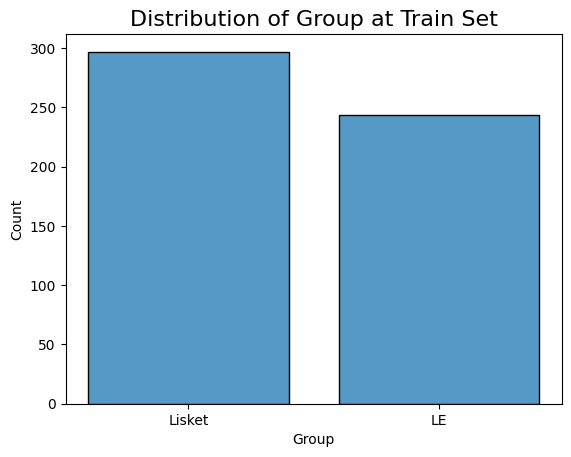

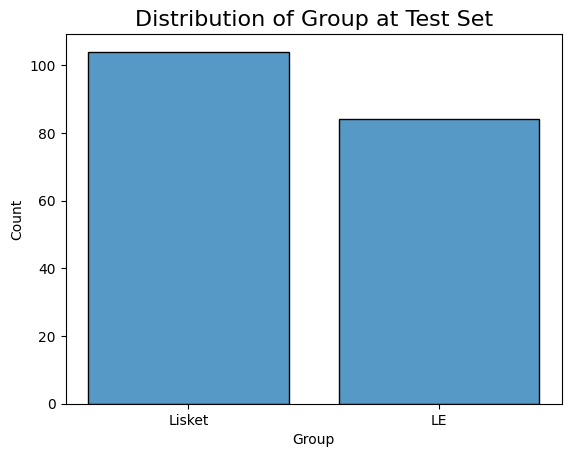

In [63]:
#Plotting label distribution in train and test sets
sns.histplot(pd.DataFrame(y_train), x='Group', multiple='dodge', shrink=0.8)
plt.title('Distribution of Group at Train Set', fontsize=16)
plt.show()


sns.histplot(pd.DataFrame(y_test), x='Group', multiple='dodge', shrink=0.8)
plt.title('Distribution of Group at Test Set', fontsize=16)
plt.show()

In [64]:
#Checking hte size of the train and test sets
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Train set size: 541, Test set size: 188


Classification Report:
              precision    recall  f1-score   support

          LE       0.69      0.85      0.76        84
      Lisket       0.85      0.69      0.76       104

    accuracy                           0.76       188
   macro avg       0.77      0.77      0.76       188
weighted avg       0.78      0.76      0.76       188



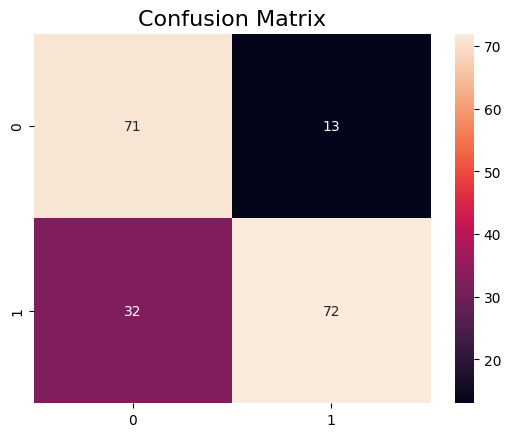

In [65]:
#Creating pipeline
pipeline = Pipeline([('tree', DecisionTreeClassifier(random_state=params['seed'], max_depth=6, min_samples_leaf=6))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix', fontsize=16)
plt.show()
# fig = ff.create_annotated_heatmap(cm, x=list(set(y_test)), y=list(set(y_test)), colorscale='Viridis')
# fig.update_layout(title='Confusion Matrix', xaxis_title='Predicted', yaxis_title='True')
# fig.write_image('data/confusion_matrix.png')
# fig.show()

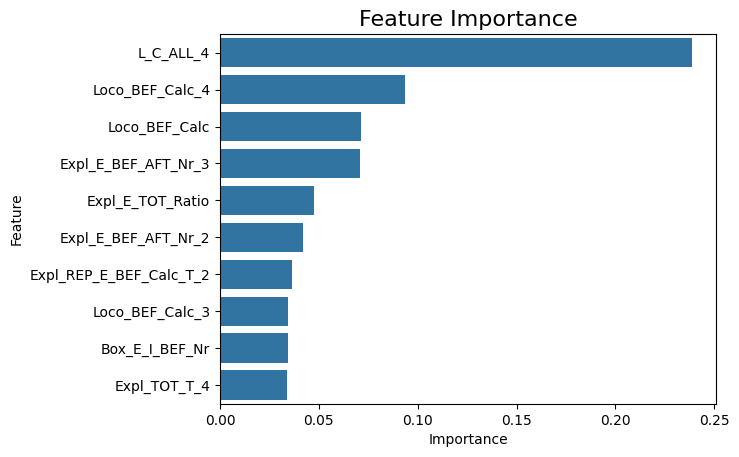

In [66]:
#Feature importance from the Decision Tree
importances = pipeline.named_steps['tree'].feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).loc[importance_df['Importance'] > 0.00001].head(10)  # Filter out low importance features
sns.barplot(importance_df, x='Importance', y='Feature', orient='h')
plt.title('Feature Importance', fontsize=16)
plt.show()


In [67]:
# Createa randomizedserach for decisiontree classifier
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': range(1, 21),
    'min_samples_split': range(2, 21, 2),
    'min_samples_leaf': range(1, 21, 2),  
    'criterion': ['gini', 'entropy']
}

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=params['seed']),
    param_distributions=param_grid,
    n_iter=10000,
    scoring='accuracy',
    cv=5,
    random_state=params['seed'],
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 11, 'max_depth': 3, 'criterion': 'gini'}
Best Score: 0.7079170914033299
